In [1]:
import thesis.jaxdaw as jd
jdist = jd.distributions

from thesis.glitch import GlitchPrior, GlitchModel

import jax
import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as ndist
from numpyro.infer import NUTS, MCMC

import pandas as pd
import arviz as az

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')
numpyro.set_host_device_count(10)

In [78]:
name = "better"
df = pd.read_csv(f"data/glitch-inputs-{name}.csv")
df.head()

,n,l,nu_true,nu,nu_err
0,15,0,2180.124902,2180.160168,0.1
1,16,0,2312.029479,2312.001039,0.1
2,17,0,2442.808410,2442.644690,0.1
3,18,0,2574.262983,2574.324094,0.1
4,19,0,2706.595870,2706.495193,0.1


In [79]:
n, nu, nu_err = df.n.to_numpy(), df.nu.to_numpy(), df.nu_err.to_numpy()

# delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)
delta_nu = jdist.Normal(132.8, 0.1)
epsilon = jdist.Normal(1.4, 0.05)
prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")
print(f"{epsilon.mean:.2f} ± {epsilon.variance**0.5:.2f}")

132.80 ± 0.10
1.40 ± 0.05


In [80]:
pyro_prior = {}
for k, v in prior.distributions.items():
    if isinstance(v, jdist.Normal):
        pyro_prior[k] = ndist.Normal(v.loc, v.scale)

In [81]:
# @numpyro.handlers.reparam(config={'phi_he': TransformReparam(), 'phi_cz': TransformReparam()})
def pyro_model():
    params = {}
    for k, v in pyro_prior.items():
        params[k] = numpyro.sample(k, v)
    
    phi_dist = ndist.Uniform(0.0, 2 * jnp.pi)
    _phi = numpyro.sample("_phi", ndist.ImproperUniform(ndist.constraints.real, (), (2,)))
    phi = jnp.remainder(_phi, 2 * jnp.pi)
    params["phi_he"] = numpyro.deterministic("phi_he", phi[0])
    params["phi_cz"] = numpyro.deterministic("phi_cz", phi[1])
    numpyro.factor(f"_phi_logp", phi_dist.log_prob(phi).sum())
    
    gp = model.build_gp(params)
    numpyro.sample("nu", gp.numpyro_dist(), obs=model.nu) 

In [83]:
sampler = NUTS(pyro_model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=10)

In [84]:
%%time
key = random.PRNGKey(0)
mcmc.run(key)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

CPU times: user 1min 55s, sys: 94.6 ms, total: 1min 55s
Wall time: 19.8 s


In [85]:
mcmc.print_summary(exclude_deterministic=False)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
       _phi[0]     -1.94      7.40      0.20    -17.39      7.47      5.51      3.38
       _phi[1]    487.38    951.02    347.93   -257.38   2099.54      8.26      2.88
      delta_nu    132.81      0.09    132.81    132.66    132.97   2194.95      1.00
       epsilon      1.41      0.03      1.41      1.35      1.46   1366.59      1.01
  log_alpha_cz      8.52      0.56      8.62      7.64      9.34   1177.48      1.02
  log_alpha_he    -11.13      0.20    -11.12    -11.45    -10.77    433.76      1.02
   log_beta_he    -15.03      0.18    -15.02    -15.32    -14.74    552.01      1.03
     log_sigma     -4.85      1.79     -4.74     -7.49     -1.83   1152.38      1.01
    log_tau_cz     -6.18      0.19     -6.12     -6.53     -5.97    108.35      1.10
    log_tau_he     -7.33      0.10     -7.34     -7.48     -7.16    382.83      1.02
        phi_cz      3.14      1.82      3.13      0.46      6.10

In [86]:
data = az.from_numpyro(mcmc)
data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

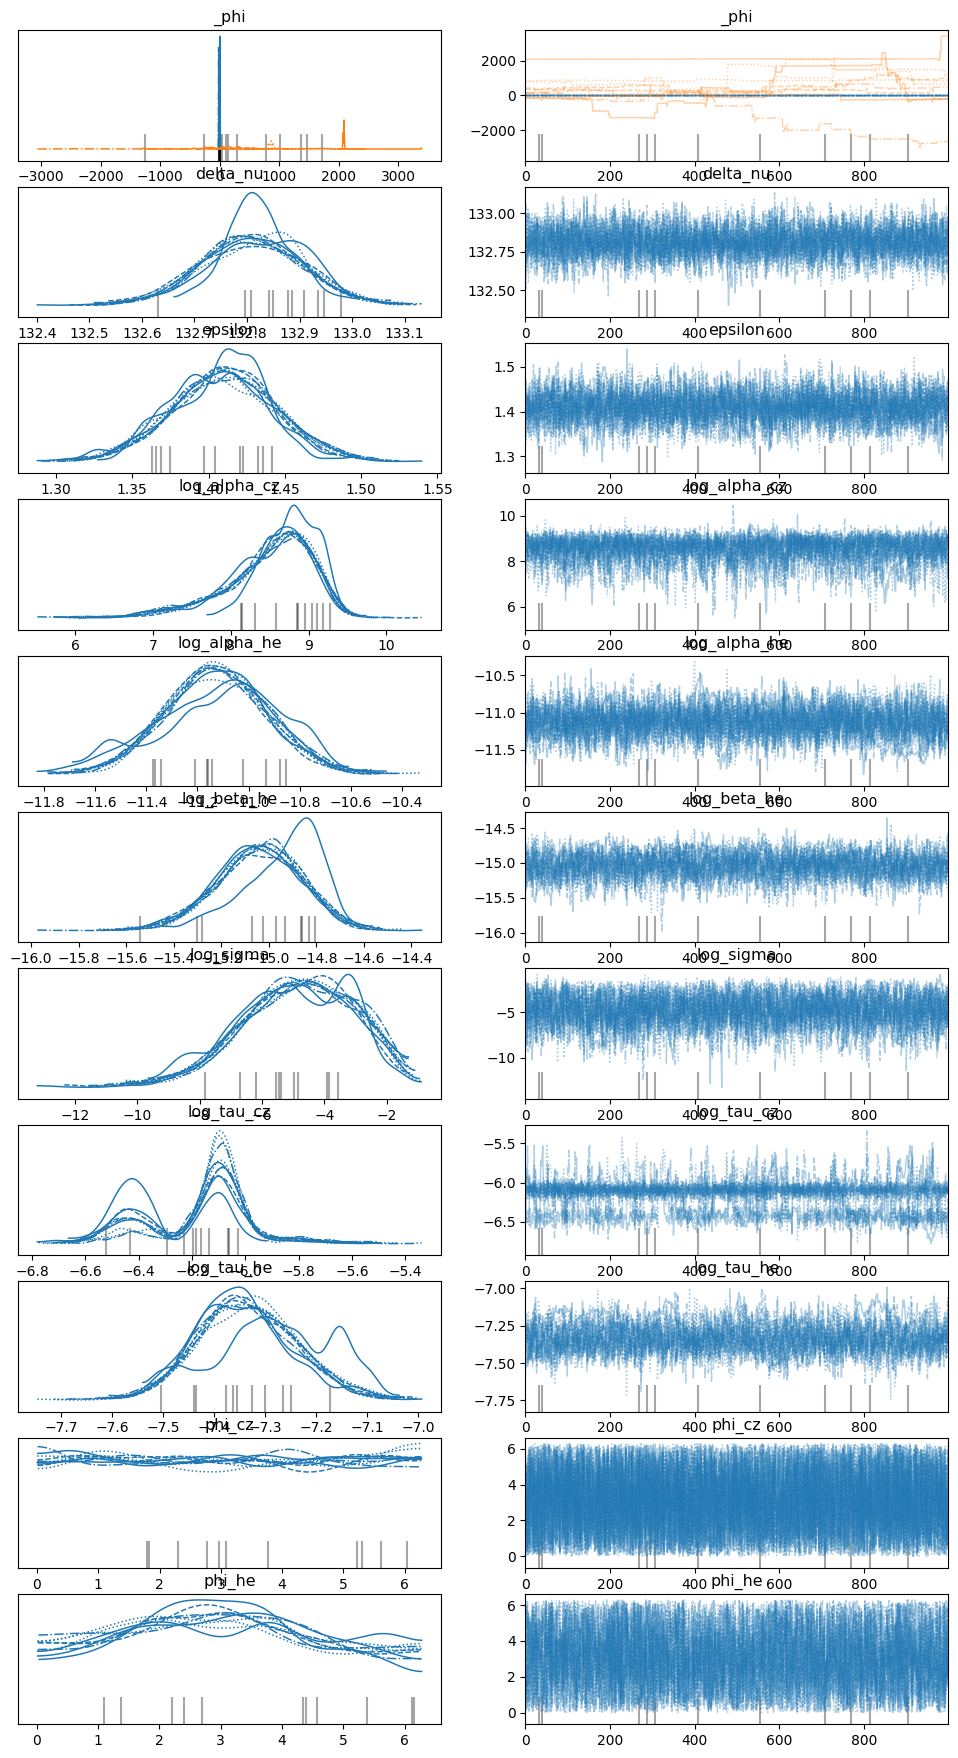

In [87]:
az.plot_trace(data);

In [88]:
samples = mcmc.get_samples()

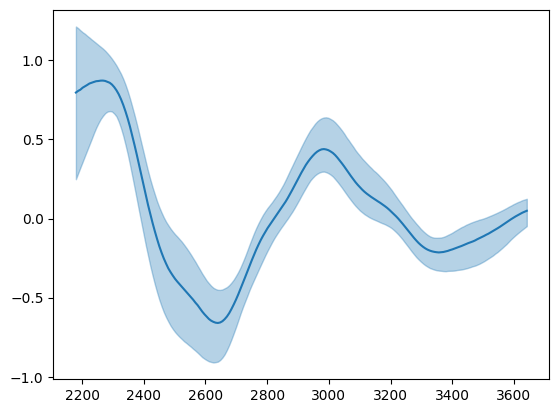

In [89]:
model.plot_glitch(samples, intervals=[(.16, .84)]);

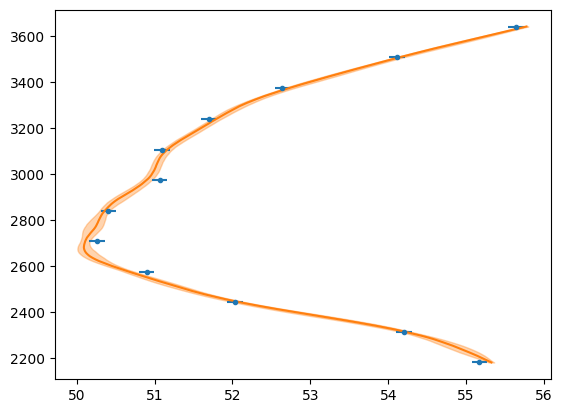

In [90]:
rng, key = random.split(key)
model.plot_echelle(key, samples, intervals=[(.16, .84)]);